In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import copy
import seaborn as sns

def ativacao(x):
    y = 1/(1+np.exp(-x))
    yl = y*(1-y)
    return y, yl

def predicao(X,pesos):
    a = X.T
    for p in pesos:
        z = np.dot(p[0],a)+p[1]
        a,_ = ativacao(z)
    return a

def construir_pesos(lst):
    pesos = []
    for i in range(len(lst)-1):
        W = np.random.randn(lst[i+1],lst[i])
        b = np.random.randn(lst[i+1],1)
        pesos.append([W,b])
    
    return pesos

def avaliarn(X,pesos):
    a = X.T
    _,al = ativacao(a)
    res = [[a,al]]### verificar aqui
    for p in pesos:
        z = np.dot(p[0],a)+p[1]
        a,al = ativacao(z)
        res.append([a,al])
    
    return res

def metricas(y_real,y_predito):
    tam0,tam1 = len(y_real[y_real == 0]),len(y_real[y_real == 1])
    tam = tam0+tam1
    tp = sum([int(y_predito[i]==1) for i in range(tam) if y_real[i]==1])
    fn = sum([int(y_predito[i]==0) for i in range(tam) if y_real[i]==1])
    tn = sum([int(y_predito[i]==0) for i in range(tam) if y_real[i]==0])
    fp = sum([int(y_predito[i]==1) for i in range(tam) if y_real[i]==0])
    acuracia = (tn+tp)/tam 
    return acuracia, [[tp/tam1,fn/tam1],[fp/tam0,tn/tam0]] 

def atualiza_par(X_train,y_train,camadas,nint=100000, lrate = 0.5,tbtach=0.2, reg = 1e-3,X_teste=[],y_teste=[]):
    ldt, nlayer,rldt = len(X_train), len(camadas),range(len(X_train))
    lte,lxte = len(y_teste),len(X_teste)

    idc = 1
    pesfct = 1
    corte = 0.07

    y_teste = y_teste.ravel()
    pesos = construir_pesos(camadas)

    npars = 0 
    for p in pesos:
        npars = npars + np.prod(p[0].shape)

    erro_tr,erro_te, acuracia_tr,acuracia_te = [],[],[],[]
    
    batch = np.array_split(rldt,round(1/tbtach))
    nbatch =  len(batch)

    acumax = 0
    pesomax = []
    

    for iter in range(nint+1):
        tamb = max(1,round(tbtach*ldt))
        X, y = [0]*tamb, [0]*tamb
        batch = random.sample(rldt,k = tamb)
        for ib,b in enumerate(batch):
            X[ib], y[ib] = X_train[b], y_train[b]
        
        # tamb = len(batch[iter%nbatch])
        # X, y = [0]*tamb, [0]*tamb
        # for ib,b in enumerate(batch[iter%nbatch]):
        #     X[ib], y[ib] = X_train[b], y_train[b]
        
        X, y = np.array(X), np.array(y)

        output = avaliarn(X,pesos)
        
        db = np.zeros(pesos[-1][1].shape)
        dw = np.zeros(pesos[-1][0].shape)

        ol = output[-1][0].ravel()
        dol = output[-1][1].ravel()

        delta = [0]*tamb
        dC = [ol-pesfct*y,-pesfct*y/ol+(1-y)/(1-ol)]
        for b in range(tamb):
            delta[b] = dol[b]*dC[idc][b]
            db = db + delta[b]
            dw = dw+delta[b]*output[-2][0].T[b]
        
        pesos[-1][0] = (1-lrate*reg/npars)*pesos[-1][0] - (lrate/tamb)*dw
        pesos[-1][1] = pesos[-1][1] - (lrate/tamb)*db


        idl = nlayer-2
        for idx in range(idl):
            id = idl-idx
            ol = output[id-1][0]
            dol = output[id][1]
            db = np.zeros(pesos[id-1][1].shape)
            dw = np.zeros(pesos[id-1][0].shape)
            for b in range(tamb):
                auxd = dol[:,b].reshape(len(dol[:,b]),1)
                delta[b] = np.dot(pesos[id][0].T,delta[b])*auxd
                db = db + delta[b]
                dw = dw+np.outer(delta[b],ol[:,b])

            pesos[id-1][0] = (1-lrate*reg/npars)*pesos[id-1][0] - (lrate/tamb)*dw
            pesos[id-1][1] = pesos[id-1][1] - (lrate/tamb)*db
        
        
        
        yp = output[-1][0]
        acutr,mtxr = metricas(y.ravel(),[int(v>corte) for v in yp.ravel()])

        custo = [np.sum((yp.ravel()-pesfct*y.ravel())**2)/tamb,-np.sum(pesfct*y*np.log(yp)+(1-y)*np.log(1-yp))/tamb]
        ncustotr = custo[idc]
        

        if lte>0 and lte==lxte:
            y_p_teste = predicao(X_teste,pesos).ravel()
            acu,mtxe = metricas(y_teste.ravel(),[int(v>corte) for v in y_p_teste])
            custoif = [np.sum((y_teste-y_p_teste)**2)/lte,-np.sum(pesfct*y_teste*np.log(y_p_teste)+(1-y_teste)*np.log(1-y_p_teste))/lte]
            ncustote = custoif[idc]
            txta = 'acuracia (teste): '+'{:.4f}'.format(mtxe[0][1])+', acuracia (treino): '+'{:.4f}'.format(mtxr[0][1])+', custo (teste): ' +'{:.4f}'.format(ncustote) +', custo (treino): ' +'{:.4f}'.format(ncustotr) + ', iteracao: '+'{:.4f}'.format(100*iter/nint)+'%'
            if acu>acumax:
                pesomax = copy.deepcopy(pesos)
                acumax = acu            
        else:
            txta = 'acuracia (treino): '+'{:.4f}'.format(acutr)+', custo (treino): ' +'{:.4f}'.format(ncustotr) + ", iteracao: "+'{:.4f}'.format(100*iter/nint)+'%'
        
        
        if (iter%10==0):
            print(txta)
        

        erro_tr.append(ncustotr)
        acuracia_te.append(acu)
        erro_te.append(ncustote)
        acuracia_tr.append(acutr)
    return pesos, {"erro_treino":erro_tr,"erro_teste":erro_te,"acuracia_treino":acuracia_tr,"acuracia_teste":acuracia_te},pesomax


In [4]:
original = pd.read_csv("dados.csv")
le = preprocessing.LabelEncoder()

modificado = pd.DataFrame()
for x in original:
    if original[x].dtypes==object:
        modificado[x] = le.fit_transform(np.array(original[x]))
    else:
        modificado[x] = np.array(original[x])


y = modificado.COMPARECEU_AGENDAMENTO_EXAME
X = modificado.drop('COMPARECEU_AGENDAMENTO_EXAME', axis=1)

Xd,yd = np.array(X), 1-np.array(y)
Xd = (Xd-Xd.min(axis=0))/(Xd.max(axis=0)-Xd.min(axis=0))
X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.25)

camadas = [len(X_train[0]),10,5,2,1]
pesos, mtr, pesomax = atualiza_par(X_train=X_train,y_train=y_train,X_teste=X_test,y_teste=y_test,camadas=camadas,lrate=.25,tbtach=0.25,nint=500,reg=2.5e-0)

acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 1.6218, custo (treino): 1.9307, iteracao: 0.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.5674, custo (treino): 0.6060, iteracao: 2.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.3721, custo (treino): 0.3755, iteracao: 4.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.3089, custo (treino): 0.3138, iteracao: 6.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.2820, custo (treino): 0.2732, iteracao: 8.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.2684, custo (treino): 0.2478, iteracao: 10.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.2612, custo (treino): 0.2619, iteracao: 12.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 0.2572, custo (treino): 0.2658, iteracao: 14.0000%
acuracia (teste): 0.0000, acuracia (treino): 0.0000, 

<AxesSubplot: title={'center': 'erro'}>

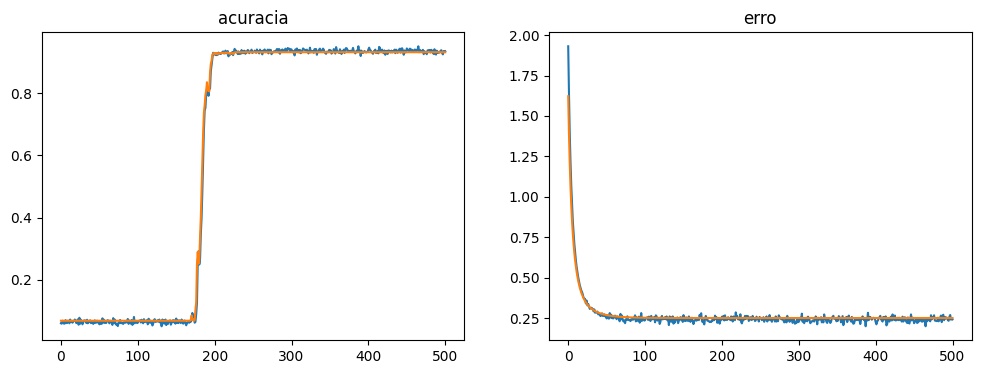

In [5]:
fig = plt.figure(figsize=(12,4))
ax1,ax2 = fig.subplots(1,2)
ax1.set_title("acuracia")
ax2.set_title("erro")
sns.lineplot(data = mtr["acuracia_treino"],ax=ax1)
sns.lineplot(data = mtr["acuracia_teste"],ax=ax1)
sns.lineplot(data = mtr["erro_treino"],ax=ax2)
sns.lineplot(data = mtr["erro_teste"],ax=ax2)

[[0.5069444444444444, 0.4930555555555556],
 [0.4974385245901639, 0.5025614754098361]]

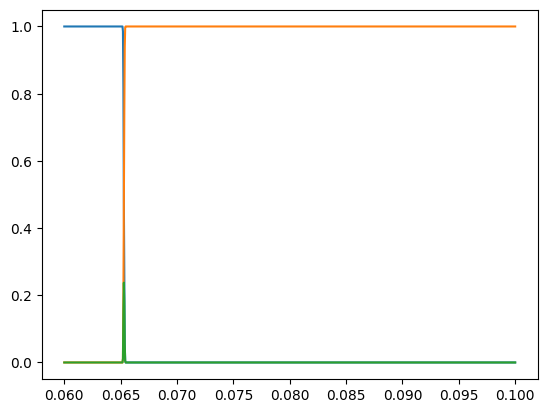

In [6]:
y_pred_tr = predicao(X=X_train,pesos=pesos).ravel()
scrs = np.linspace(0.06,.1,1000)
xx,yy,age = [],[],[]
for vl in scrs:
    acu,mtx = metricas(y_train,[int(v>vl) for v in y_pred_tr])
    xx.append(mtx[0][0])
    yy.append(mtx[1][1])
    age.append(mtx[0][0]*mtx[1][1])
sns.lineplot(x=scrs,y=xx)
sns.lineplot(x=scrs,y=yy)

vl = scrs[np.argmin((np.array(xx)-np.array(yy))**2)]
y_pred = predicao(X=X_test,pesos=pesos).ravel()
acu,mtx = metricas(y_test,[int(v>vl) for v in y_pred])
mtx

<AxesSubplot: >

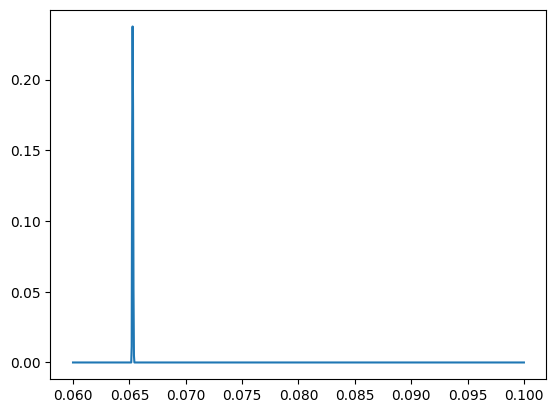

In [7]:
sns.lineplot(x=scrs,y=age)


<AxesSubplot: >

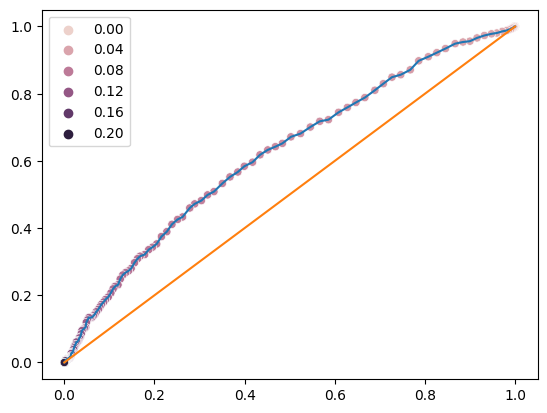

In [36]:
y_pred_tr = predicao(X=X_train,pesos=pesos).ravel()
scrs = np.linspace(0,.2,200)
x = []
y = []
for vl in scrs:
    acu,mtx = metricas(y_train,[int(v>vl) for v in y_pred_tr])
    y.append(mtx[0][0])
    x.append(mtx[1][0])
sns.lineplot(x=x,y=y)
sns.scatterplot(x=x,y=y,hue=scrs)
sns.lineplot(x=[0,1],y=[0,1])
